<a href="https://colab.research.google.com/github/toufiqmusah/HeadCT-SRGAN/blob/main/Head_CT_SRGAN_IMPLEMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###IMPORTING NEEDED LIBRARIES

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

###DEFINING BLOCKS TO BUILD GENERATOR

In [2]:
def res_block(ip):
  res_model = Conv2D(128, (3, 3), padding = 'same')(ip)
  res_model = BatchNormalization(momentum = 0.5)(res_model)
  res_model = PReLU(shared_axes = [1, 2])(res_model)

  res_model = Conv2D(128, (3, 3), padding = 'same')(res_model)
  res_model = BatchNormalization(momentum = 0.5)(res_model)

  return add([ip, res_model])

def upscale_block(ip):
  up_model = Conv2D(512, (3, 3), padding = 'same')(ip)
  up_model = UpSampling2D(size = 2)(up_model)
  up_model = PReLU(shared_axes = [1, 2])(up_model)

  return up_model

###GENERATOR MODEL

In [3]:
def create_gen(gen_ip, num_res_block):
  layers = Conv2D(128, (9, 9), padding = 'same')(gen_ip)
  layers = PReLU(shared_axes = [1, 2])(layers)

  temp = layers

  for i in range(num_res_block):
    layers = res_block(layers)

  layers = Conv2D(128, (3, 3), padding = 'same')(layers)
  layers = BatchNormalization(momentum = 0.5)(layers)
  layers = add([layers, temp])

  layers = upscale_block(layers)
  layers = upscale_block(layers)

  op = Conv2D(3, (9, 9), padding = 'same')(layers)

  return Model(inputs = gen_ip, outputs = op)

###DEFINING BLOCKS TO BUILD DISCRIMINATOR

In [4]:
def discriminator_block(ip, filters, strides = 1, bn = True):
  disc_model = Conv2D(filters, (3, 3), strides = strides,
                      padding = 'same')(ip)

  if bn:
    disc_model = BatchNormalization(momentum = 0.8)(disc_model)

  disc_model = LeakyReLU(alpha = 0.2)(disc_model)

  return disc_model

###DISCRIMINATOR MODEL

In [5]:
def create_disc(disc_ip):
  df = 32

  d1 = discriminator_block(disc_ip, df, bn = False)
  d2 = discriminator_block(d1, df, strides = 2)
  d3 = discriminator_block(d2, df*2)
  d4 = discriminator_block(d3, df*2, strides = 2)
  d5 = discriminator_block(d4, df*4)
  d6 = discriminator_block(d5, df*4, strides = 2)
  d7 = discriminator_block(d6, df*8)
  d8 = discriminator_block(d7, df*8, strides = 2)

  d8_5 = Flatten()(d8)
  d9 = Dense(df*16)(d8_5)
  d10 = LeakyReLU(alpha = 0.2)(d9)
  validity = Dense(1, activation = 'sigmoid')(d10)

  return Model(disc_ip, validity)


###USING A PRE-TRAINED VGG19 MODEL
-FOR FEATURE EXTRACTION AT THE 3RD CONV BLOCK

In [6]:
from keras.applications import VGG19

def build_vgg(hr_shape):
  vgg = VGG19(weights = 'imagenet', include_top = False,
              input_shape = hr_shape)

  return Model(inputs = vgg.inputs, outputs = vgg.layers[10].output)

###COMBINED GENERATIR + DISCRIMINATOR MODEL

In [7]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
  gen_img = gen_model(lr_ip)
  gen_features = vgg(gen_img)

  disc_model.trainable = False
  validity = disc_model(gen_img)

  return Model(inputs = [lr_ip, hr_ip],
               outputs = [validity, gen_features])

###LOADING TRAINING DATA

* LR: LOW RESOLUTION
* HR: HIGH RESOLUTION
* HCT: HEAD CT

In [8]:
!gdown 1ssSf_fdvxIGYSG98bopF6wGYolwFgUbG --quiet

In [9]:
!unzip HeadCT-SRGAN.zip

Archive:  HeadCT-SRGAN.zip
  inflating: HR_HCT/ct1.png          
  inflating: HR_HCT/ct10.png         
  inflating: HR_HCT/ct100.png        
  inflating: HR_HCT/ct101.png        
  inflating: HR_HCT/ct102.png        
  inflating: HR_HCT/ct103.png        
  inflating: HR_HCT/ct104.png        
  inflating: HR_HCT/ct105.png        
  inflating: HR_HCT/ct106.png        
  inflating: HR_HCT/ct107.png        
  inflating: HR_HCT/ct108.png        
  inflating: HR_HCT/ct109.png        
  inflating: HR_HCT/ct11.png         
  inflating: HR_HCT/ct110.png        
  inflating: HR_HCT/ct111.png        
  inflating: HR_HCT/ct112.png        
  inflating: HR_HCT/ct113.png        
  inflating: HR_HCT/ct114.png        
  inflating: HR_HCT/ct115.png        
  inflating: HR_HCT/ct116.png        
  inflating: HR_HCT/ct117.png        
  inflating: HR_HCT/ct118.png        
  inflating: HR_HCT/ct119.png        
  inflating: HR_HCT/ct12.png         
  inflating: HR_HCT/ct120.png        
  inflating: HR_HCT/ct1

##LOADING 150 HEAD CTS TO TRAIN


*   CHANGE lr_path and hr_path in the following cells to the appropriate path names of the downloaded dataset if not working in google colab.



In [10]:
n = 150

lr_path = '/content/LR_HCT'
lr_list = os.listdir(lr_path)[:n]
lr_list = np.sort(lr_list)
lr_images = []

for img in lr_list:
  img_lr = cv2.imread(lr_path + '/' + img)
  img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
  lr_images.append(img_lr)

In [11]:
hr_path = '/content/HR_HCT'
hr_list = os.listdir(hr_path)[:n]
hr_list = np.sort(hr_list)
hr_images = []

for img in hr_list:
  img_hr = cv2.imread(hr_path + '/' + img)
  img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
  hr_images.append(img_hr)

In [12]:
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

###SANITY CHECK BY VIEWING A FEW LOADED IMAGES

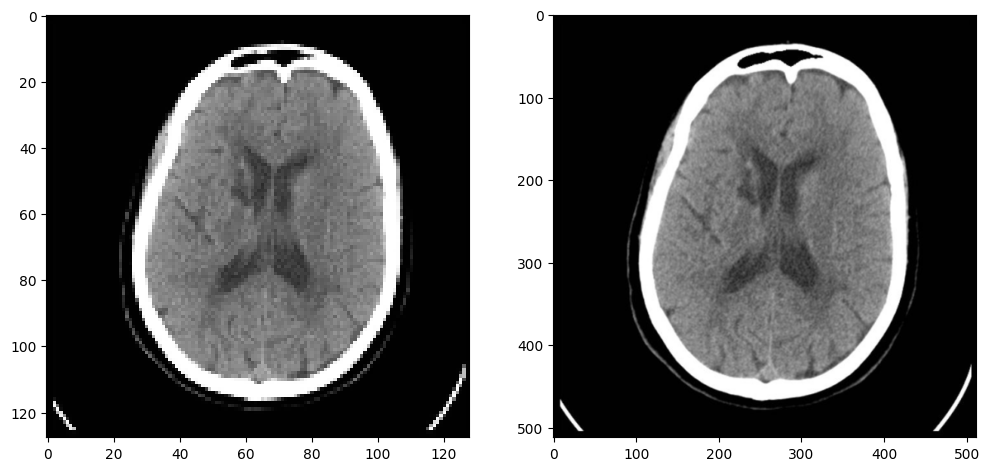

In [13]:
import random
import numpy as np

image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (128, 128, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (512, 512, 3)))
plt.show()

###SCALING VALUES AND SPLITTING IN TO TRAIN/TEST

In [14]:
lr_images = lr_images/255
hr_images = hr_images/255

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images,
                                                        hr_images,
                                                        test_size = 0.2,
                                                        random_state = 42)

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

hr_shape

(512, 512, 3)

In [15]:
lr_ip = Input(shape = lr_shape)
hr_ip = Input(shape = hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 128)        31232     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 128, 128, 128)        128       ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 128)        147584    ['p_re_lu[0][0]']             
                                                                                              

In [16]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam',
                      metrics = ['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 512, 512, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512, 512, 32)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_33 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 32)      0         
                                                           

In [17]:
vgg = build_vgg((512, 512, 3))
vgg.trainable = False
vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                            

In [18]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss = ['binary_crossentropy', 'mse'],
                  loss_weights = [1e-3, 1], optimizer = 'adam')
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 512, 512, 3)          7996163   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    1353947   ['model[0][0]']               
                                                          21                                

###SETTING UP AND TRAINING DISCRIMINATOR+GENERATOR
* This takes a while.
* The generator model from every epoch is saved.
* Pick and Choose which is best by checking g_loss of a given epoch👍(Lower is Good)

In [20]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
  start_idx = it * batch_size
  end_idx = start_idx + batch_size
  train_hr_batches.append(hr_train[start_idx:end_idx])
  train_lr_batches.append(lr_train[start_idx:end_idx])

epochs = 10

for e in range(epochs):
  fake_label = np.zeros((batch_size, 1)) #Assign Zeros To Fake Generations
  real_label = np.ones((batch_size, 1)) #Assign Ones To Real Images
  #Empty List To Populate Gen/Disc Losses
  g_losses = []
  d_losses = []

  for b in tqdm(range(len(train_hr_batches))):
    lr_imgs = train_lr_batches[b]
    hr_imgs = train_hr_batches[b]

    fake_imgs = generator.predict_on_batch(lr_imgs)

    discriminator.trainable = True
    d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
    d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

    #Training Generator Now

    discriminator.trainable = False
    d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
    #Averaging Discriminator Loss

    image_features = vgg.predict(hr_imgs)
    #Accounting For Adversarial and Content(VGG) Loss
    g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs],
                                            [real_label, image_features])

    #Saving Losses To A List
    d_losses.append(d_loss)
    g_losses.append(g_loss)

  g_losses = np.array(g_losses)
  d_losses = np.array(d_losses)

  #Reporting Training Progress
  print(f"epoch: {e+1}, g_loss: {g_loss}, d_loss: {d_loss}")
  #if g_loss <= 10:
  generator.save("gen_e_" + str(e+1) + ".h5")


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 1s 984ms/step


  1%|          | 1/120 [00:56<1:52:33, 56.75s/it]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 2/120 [00:57<47:20, 24.07s/it]  

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 3/120 [00:59<26:28, 13.57s/it]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/120 [01:00<16:43,  8.65s/it]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 5/120 [01:01<11:23,  5.94s/it]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 6/120 [01:02<08:10,  4.30s/it]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 7/120 [01:03<06:07,  3.25s/it]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 8/120 [01:04<04:47,  2.56s/it]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 9/120 [01:05<03:59,  2.16s/it]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 10/120 [01:07<03:29,  1.91s/it]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 11/120 [01:08<03:01,  1.66s/it]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 12/120 [01:09<02:41,  1.50s/it]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 13/120 [01:10<02:28,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 14/120 [01:11<02:17,  1.30s/it]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 15/120 [01:12<02:10,  1.24s/it]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 16/120 [01:13<02:03,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 17/120 [01:14<01:59,  1.16s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 18/120 [01:15<01:56,  1.14s/it]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 19/120 [01:17<02:12,  1.31s/it]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 20/120 [01:18<02:07,  1.28s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 21/120 [01:20<02:01,  1.23s/it]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 22/120 [01:21<01:57,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 23/120 [01:22<01:53,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 24/120 [01:23<01:51,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 25/120 [01:24<01:50,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 26/120 [01:25<01:47,  1.14s/it]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 27/120 [01:26<01:49,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 28/120 [01:28<01:46,  1.15s/it]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 29/120 [01:29<01:59,  1.32s/it]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 30/120 [01:31<01:58,  1.31s/it]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 31/120 [01:32<02:11,  1.48s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 32/120 [01:34<02:00,  1.37s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 33/120 [01:35<01:52,  1.29s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 34/120 [01:36<01:46,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 35/120 [01:37<01:42,  1.21s/it]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 36/120 [01:38<01:38,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 37/120 [01:39<01:37,  1.17s/it]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 38/120 [01:41<01:48,  1.32s/it]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 39/120 [01:42<01:44,  1.29s/it]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 40/120 [01:43<01:39,  1.24s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 41/120 [01:44<01:35,  1.21s/it]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 42/120 [01:45<01:32,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 43/120 [01:47<01:30,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 44/120 [01:48<01:28,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 45/120 [01:49<01:26,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 46/120 [01:50<01:24,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 47/120 [01:51<01:23,  1.14s/it]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 48/120 [01:53<01:33,  1.30s/it]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 49/120 [01:54<01:33,  1.31s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 50/120 [01:55<01:27,  1.26s/it]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 51/120 [01:56<01:25,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 52/120 [01:58<01:21,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 53/120 [01:59<01:19,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 54/120 [02:00<01:17,  1.17s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 55/120 [02:01<01:15,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 56/120 [02:02<01:13,  1.15s/it]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 57/120 [02:03<01:12,  1.15s/it]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 58/120 [02:04<01:12,  1.17s/it]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 59/120 [02:06<01:15,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 60/120 [02:07<01:11,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 61/120 [02:08<01:09,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 62/120 [02:09<01:07,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 63/120 [02:11<01:16,  1.34s/it]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 64/120 [02:12<01:11,  1.27s/it]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 65/120 [02:13<01:08,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 66/120 [02:14<01:05,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 67/120 [02:16<01:03,  1.20s/it]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 68/120 [02:17<01:13,  1.40s/it]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 69/120 [02:19<01:07,  1.33s/it]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 70/120 [02:20<01:05,  1.32s/it]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 71/120 [02:21<01:02,  1.27s/it]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 72/120 [02:22<00:59,  1.23s/it]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 73/120 [02:23<00:57,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 74/120 [02:25<00:55,  1.20s/it]

1/1 [==============================] - 0s 26ms/step


 62%|██████▎   | 75/120 [02:26<00:53,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 76/120 [02:27<00:51,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 77/120 [02:28<00:49,  1.16s/it]

1/1 [==============================] - 0s 51ms/step


 65%|██████▌   | 78/120 [02:29<00:51,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 79/120 [02:30<00:48,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 80/120 [02:32<00:47,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 81/120 [02:33<00:45,  1.16s/it]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 82/120 [02:34<00:43,  1.16s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 83/120 [02:35<00:42,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 84/120 [02:37<00:47,  1.31s/it]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 85/120 [02:38<00:44,  1.26s/it]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 86/120 [02:39<00:41,  1.23s/it]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 87/120 [02:41<00:45,  1.37s/it]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 88/120 [02:42<00:43,  1.36s/it]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 89/120 [02:43<00:40,  1.31s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 90/120 [02:44<00:37,  1.26s/it]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 91/120 [02:45<00:35,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 92/120 [02:47<00:33,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 93/120 [02:48<00:31,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 94/120 [02:49<00:30,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 95/120 [02:50<00:28,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 96/120 [02:51<00:27,  1.15s/it]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 97/120 [02:53<00:30,  1.34s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 98/120 [02:54<00:28,  1.30s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▎ | 99/120 [02:55<00:26,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 100/120 [02:56<00:24,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 101/120 [02:57<00:22,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 102/120 [02:59<00:21,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 103/120 [03:00<00:19,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 104/120 [03:01<00:18,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 105/120 [03:02<00:17,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 106/120 [03:04<00:18,  1.30s/it]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 107/120 [03:06<00:19,  1.48s/it]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 108/120 [03:07<00:16,  1.39s/it]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 109/120 [03:08<00:14,  1.32s/it]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 110/120 [03:09<00:12,  1.26s/it]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 111/120 [03:10<00:11,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 112/120 [03:11<00:09,  1.21s/it]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 113/120 [03:13<00:08,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 114/120 [03:14<00:08,  1.35s/it]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 115/120 [03:16<00:07,  1.45s/it]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 116/120 [03:17<00:05,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 117/120 [03:18<00:04,  1.34s/it]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 118/120 [03:20<00:02,  1.28s/it]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 119/120 [03:21<00:01,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 120/120 [03:22<00:00,  1.69s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch: 1, g_loss: 18.101369857788086, d_loss: [0. 1.]


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/120 [00:01<02:13,  1.12s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/120 [00:02<02:12,  1.13s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 3/120 [00:03<02:12,  1.13s/it]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/120 [00:04<02:10,  1.13s/it]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 5/120 [00:06<02:36,  1.36s/it]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 6/120 [00:07<02:26,  1.28s/it]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 7/120 [00:08<02:20,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 8/120 [00:09<02:14,  1.20s/it]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 9/120 [00:10<02:11,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 10/120 [00:11<02:09,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 11/120 [00:13<02:06,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 12/120 [00:14<02:04,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 13/120 [00:15<02:02,  1.15s/it]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 14/120 [00:17<02:18,  1.30s/it]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 15/120 [00:18<02:14,  1.28s/it]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 16/120 [00:19<02:08,  1.23s/it]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 17/120 [00:20<02:04,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 18/120 [00:21<02:01,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 19/120 [00:22<01:59,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 20/120 [00:24<01:57,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 21/120 [00:25<01:55,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 22/120 [00:26<01:56,  1.19s/it]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 23/120 [00:27<01:54,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 24/120 [00:29<02:09,  1.35s/it]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 25/120 [00:30<02:03,  1.30s/it]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 26/120 [00:31<01:58,  1.26s/it]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 27/120 [00:32<01:54,  1.23s/it]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 28/120 [00:33<01:50,  1.20s/it]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 29/120 [00:35<01:48,  1.19s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 30/120 [00:36<01:46,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 31/120 [00:37<01:44,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 32/120 [00:38<01:43,  1.18s/it]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 33/120 [00:39<01:41,  1.17s/it]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 34/120 [00:41<01:55,  1.34s/it]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 35/120 [00:43<02:04,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 36/120 [00:44<01:54,  1.36s/it]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 37/120 [00:45<01:47,  1.29s/it]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 38/120 [00:46<01:42,  1.25s/it]

1/1 [==============================] - 0s 17ms/step


 32%|███▎      | 39/120 [00:47<01:38,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 40/120 [00:48<01:35,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 41/120 [00:50<01:33,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 42/120 [00:51<01:31,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 43/120 [00:52<01:41,  1.32s/it]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 44/120 [00:54<01:38,  1.29s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 45/120 [00:55<01:33,  1.25s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 46/120 [00:56<01:30,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 47/120 [00:57<01:26,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 48/120 [00:58<01:23,  1.16s/it]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 49/120 [00:59<01:22,  1.16s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 50/120 [01:00<01:20,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 51/120 [01:02<01:18,  1.14s/it]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 52/120 [01:03<01:16,  1.13s/it]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 53/120 [01:04<01:27,  1.30s/it]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 54/120 [01:06<01:26,  1.31s/it]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 55/120 [01:07<01:21,  1.26s/it]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 56/120 [01:08<01:17,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 57/120 [01:09<01:14,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 58/120 [01:10<01:12,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 59/120 [01:11<01:10,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 60/120 [01:12<01:09,  1.15s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 61/120 [01:14<01:08,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 62/120 [01:15<01:06,  1.14s/it]

1/1 [==============================] - 0s 30ms/step


 52%|█████▎    | 63/120 [01:17<01:16,  1.33s/it]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 64/120 [01:18<01:13,  1.31s/it]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 65/120 [01:19<01:09,  1.26s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 66/120 [01:20<01:05,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 67/120 [01:21<01:03,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 68/120 [01:22<01:00,  1.17s/it]

1/1 [==============================] - 0s 21ms/step


 57%|█████▊    | 69/120 [01:24<01:00,  1.18s/it]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 70/120 [01:25<00:58,  1.17s/it]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 71/120 [01:26<00:56,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 72/120 [01:27<01:03,  1.32s/it]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 73/120 [01:29<01:02,  1.33s/it]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 74/120 [01:30<00:58,  1.28s/it]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 75/120 [01:31<00:56,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 76/120 [01:32<00:53,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 77/120 [01:33<00:50,  1.18s/it]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 78/120 [01:35<00:49,  1.19s/it]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 79/120 [01:37<00:58,  1.43s/it]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 80/120 [01:39<01:04,  1.61s/it]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 81/120 [01:40<01:02,  1.60s/it]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 82/120 [01:42<00:58,  1.53s/it]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 83/120 [01:43<00:52,  1.41s/it]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 84/120 [01:44<00:48,  1.34s/it]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 85/120 [01:45<00:44,  1.28s/it]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 86/120 [01:46<00:41,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 87/120 [01:47<00:40,  1.22s/it]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 88/120 [01:49<00:38,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 89/120 [01:50<00:36,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 90/120 [01:51<00:35,  1.18s/it]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 91/120 [01:53<00:40,  1.40s/it]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 92/120 [01:54<00:36,  1.31s/it]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 93/120 [01:55<00:34,  1.27s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 94/120 [01:56<00:31,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 95/120 [01:57<00:29,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 96/120 [01:58<00:28,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 97/120 [02:00<00:26,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 98/120 [02:01<00:25,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 99/120 [02:02<00:27,  1.32s/it]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 100/120 [02:04<00:28,  1.44s/it]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 101/120 [02:05<00:26,  1.39s/it]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 102/120 [02:07<00:23,  1.31s/it]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 103/120 [02:08<00:21,  1.25s/it]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 104/120 [02:09<00:19,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 105/120 [02:10<00:17,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 106/120 [02:11<00:16,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 107/120 [02:12<00:15,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 108/120 [02:13<00:13,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 109/120 [02:14<00:12,  1.14s/it]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 110/120 [02:16<00:13,  1.34s/it]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 111/120 [02:17<00:11,  1.28s/it]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 112/120 [02:18<00:09,  1.23s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 113/120 [02:20<00:08,  1.21s/it]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 114/120 [02:21<00:07,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 115/120 [02:22<00:05,  1.17s/it]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 116/120 [02:23<00:04,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 117/120 [02:24<00:03,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 118/120 [02:25<00:02,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 119/120 [02:27<00:01,  1.16s/it]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 120/120 [02:28<00:00,  1.24s/it]


epoch: 2, g_loss: 12.427194595336914, d_loss: [61.99502563  0.5       ]


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/120 [00:01<02:16,  1.15s/it]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 2/120 [00:02<02:13,  1.13s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▎         | 3/120 [00:03<02:14,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/120 [00:04<02:14,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 5/120 [00:05<02:11,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 6/120 [00:06<02:10,  1.14s/it]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 7/120 [00:08<02:08,  1.14s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 8/120 [00:09<02:08,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 9/120 [00:10<02:25,  1.31s/it]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 10/120 [00:12<02:19,  1.27s/it]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 11/120 [00:13<02:14,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 12/120 [00:14<02:10,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 13/120 [00:15<02:06,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 14/120 [00:16<02:04,  1.17s/it]

1/1 [==============================] - 0s 17ms/step


 12%|█▎        | 15/120 [00:17<02:01,  1.15s/it]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 16/120 [00:18<02:00,  1.15s/it]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 17/120 [00:19<01:58,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 18/120 [00:21<01:56,  1.14s/it]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 19/120 [00:22<02:13,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 20/120 [00:24<02:11,  1.31s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 21/120 [00:25<02:04,  1.26s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 22/120 [00:26<02:00,  1.23s/it]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 23/120 [00:27<01:56,  1.21s/it]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 24/120 [00:28<01:54,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 25/120 [00:29<01:52,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 26/120 [00:31<01:50,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 27/120 [00:32<01:47,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 28/120 [00:34<02:05,  1.37s/it]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 29/120 [00:35<02:04,  1.37s/it]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 30/120 [00:36<01:56,  1.30s/it]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 31/120 [00:37<01:51,  1.25s/it]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 32/120 [00:38<01:46,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 33/120 [00:39<01:43,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 34/120 [00:41<01:40,  1.17s/it]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 35/120 [00:42<01:38,  1.16s/it]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 36/120 [00:43<01:37,  1.15s/it]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 37/120 [00:44<01:36,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 38/120 [00:46<01:49,  1.34s/it]

1/1 [==============================] - 0s 36ms/step


 32%|███▎      | 39/120 [00:47<01:45,  1.30s/it]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 40/120 [00:48<01:40,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 41/120 [00:49<01:36,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 42/120 [00:50<01:33,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 43/120 [00:52<01:30,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 44/120 [00:53<01:28,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 45/120 [00:54<01:26,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 46/120 [00:55<01:26,  1.16s/it]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 47/120 [00:56<01:24,  1.16s/it]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 48/120 [00:58<01:28,  1.22s/it]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 49/120 [00:59<01:26,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 50/120 [01:00<01:23,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 51/120 [01:01<01:22,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 52/120 [01:02<01:20,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 53/120 [01:03<01:18,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 54/120 [01:05<01:28,  1.34s/it]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 55/120 [01:06<01:23,  1.29s/it]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 56/120 [01:07<01:19,  1.24s/it]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 57/120 [01:09<01:16,  1.22s/it]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 58/120 [01:10<01:18,  1.26s/it]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 59/120 [01:11<01:15,  1.24s/it]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 60/120 [01:12<01:13,  1.23s/it]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 61/120 [01:13<01:10,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 62/120 [01:15<01:09,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 63/120 [01:16<01:06,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 64/120 [01:17<01:05,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 65/120 [01:18<01:04,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 66/120 [01:19<01:02,  1.16s/it]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 67/120 [01:20<01:01,  1.16s/it]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 68/120 [01:22<01:03,  1.22s/it]

1/1 [==============================] - 0s 29ms/step


 57%|█████▊    | 69/120 [01:23<01:02,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 70/120 [01:24<01:00,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 71/120 [01:25<00:57,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 72/120 [01:26<00:55,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 73/120 [01:28<00:54,  1.16s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 74/120 [01:29<00:52,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 75/120 [01:30<00:51,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 76/120 [01:31<00:50,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 77/120 [01:32<00:49,  1.15s/it]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 78/120 [01:34<00:55,  1.32s/it]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 79/120 [01:35<00:52,  1.28s/it]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 80/120 [01:37<00:56,  1.42s/it]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 81/120 [01:38<00:51,  1.33s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 82/120 [01:39<00:48,  1.27s/it]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 83/120 [01:40<00:45,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 84/120 [01:41<00:43,  1.22s/it]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 85/120 [01:42<00:41,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 86/120 [01:44<00:39,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 87/120 [01:45<00:43,  1.32s/it]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 88/120 [01:47<00:41,  1.29s/it]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 89/120 [01:48<00:38,  1.24s/it]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 90/120 [01:49<00:36,  1.21s/it]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 91/120 [01:50<00:34,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 92/120 [01:51<00:32,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 93/120 [01:52<00:31,  1.16s/it]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 94/120 [01:53<00:30,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 95/120 [01:55<00:28,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 96/120 [01:56<00:27,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 97/120 [01:57<00:30,  1.32s/it]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 98/120 [01:59<00:28,  1.28s/it]

1/1 [==============================] - 0s 20ms/step


 82%|████████▎ | 99/120 [02:00<00:25,  1.24s/it]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 100/120 [02:01<00:27,  1.38s/it]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 101/120 [02:03<00:24,  1.31s/it]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 102/120 [02:04<00:22,  1.26s/it]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 103/120 [02:05<00:20,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 104/120 [02:06<00:19,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 105/120 [02:07<00:17,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 106/120 [02:08<00:16,  1.17s/it]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 107/120 [02:10<00:15,  1.22s/it]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 108/120 [02:11<00:15,  1.26s/it]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 109/120 [02:12<00:13,  1.22s/it]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 110/120 [02:13<00:12,  1.20s/it]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▎| 111/120 [02:14<00:10,  1.20s/it]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 112/120 [02:16<00:09,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 113/120 [02:17<00:08,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 114/120 [02:18<00:06,  1.16s/it]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 115/120 [02:19<00:05,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 116/120 [02:20<00:04,  1.15s/it]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 117/120 [02:21<00:03,  1.17s/it]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 118/120 [02:23<00:02,  1.22s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 119/120 [02:24<00:01,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 120/120 [02:25<00:00,  1.21s/it]


epoch: 3, g_loss: 14.009546279907227, d_loss: [6.70256517e-09 1.00000000e+00]


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/120 [00:01<02:14,  1.13s/it]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 2/120 [00:02<02:17,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


  2%|▎         | 3/120 [00:03<02:13,  1.14s/it]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/120 [00:04<02:14,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 5/120 [00:05<02:11,  1.14s/it]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 6/120 [00:06<02:10,  1.14s/it]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 7/120 [00:08<02:09,  1.15s/it]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 8/120 [00:09<02:16,  1.22s/it]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 9/120 [00:10<02:13,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 10/120 [00:11<02:10,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 11/120 [00:12<02:06,  1.16s/it]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 12/120 [00:13<02:04,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 13/120 [00:15<02:03,  1.15s/it]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 14/120 [00:16<02:02,  1.15s/it]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 15/120 [00:17<02:00,  1.15s/it]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 16/120 [00:18<02:00,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 17/120 [00:19<01:58,  1.15s/it]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 18/120 [00:21<02:18,  1.36s/it]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 19/120 [00:22<02:10,  1.29s/it]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 20/120 [00:23<02:05,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 21/120 [00:24<02:00,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 22/120 [00:26<01:56,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 23/120 [00:27<01:53,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 24/120 [00:28<01:50,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 25/120 [00:29<01:50,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 26/120 [00:30<01:48,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 27/120 [00:32<02:02,  1.31s/it]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 28/120 [00:33<02:00,  1.31s/it]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 29/120 [00:34<01:54,  1.26s/it]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 30/120 [00:35<01:49,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 31/120 [00:37<01:46,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 32/120 [00:38<01:43,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 33/120 [00:39<01:42,  1.18s/it]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 34/120 [00:40<01:40,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 35/120 [00:41<01:37,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 36/120 [00:42<01:36,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 37/120 [00:44<01:48,  1.31s/it]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 38/120 [00:45<01:45,  1.29s/it]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 39/120 [00:46<01:41,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 40/120 [00:48<01:38,  1.23s/it]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 41/120 [00:49<01:34,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 42/120 [00:50<01:31,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 43/120 [00:51<01:30,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 44/120 [00:52<01:28,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 45/120 [00:54<01:39,  1.32s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 46/120 [00:56<01:45,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 47/120 [00:57<01:43,  1.41s/it]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 48/120 [00:58<01:35,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 49/120 [00:59<01:30,  1.28s/it]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 50/120 [01:00<01:27,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 51/120 [01:01<01:23,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 52/120 [01:03<01:20,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 53/120 [01:04<01:18,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 54/120 [01:05<01:17,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 55/120 [01:06<01:16,  1.18s/it]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 56/120 [01:07<01:16,  1.19s/it]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 57/120 [01:09<01:17,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 58/120 [01:10<01:14,  1.21s/it]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 59/120 [01:11<01:12,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 60/120 [01:12<01:11,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 61/120 [01:13<01:09,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 62/120 [01:14<01:07,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 52%|█████▎    | 63/120 [01:16<01:05,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 64/120 [01:17<01:04,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 65/120 [01:18<01:03,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 66/120 [01:20<01:11,  1.32s/it]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 67/120 [01:21<01:07,  1.28s/it]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 68/120 [01:22<01:04,  1.23s/it]

1/1 [==============================] - 0s 23ms/step


 57%|█████▊    | 69/120 [01:23<01:01,  1.22s/it]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 70/120 [01:24<01:00,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 71/120 [01:25<00:58,  1.19s/it]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 72/120 [01:27<01:04,  1.35s/it]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 73/120 [01:28<01:00,  1.28s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 74/120 [01:29<00:56,  1.24s/it]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 75/120 [01:31<00:55,  1.23s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 76/120 [01:32<00:55,  1.25s/it]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 77/120 [01:33<00:52,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 78/120 [01:34<00:49,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 79/120 [01:35<00:48,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 80/120 [01:36<00:46,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 81/120 [01:38<00:45,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 82/120 [01:39<00:44,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 83/120 [01:40<00:42,  1.16s/it]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 84/120 [01:42<00:47,  1.32s/it]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 85/120 [01:43<00:44,  1.26s/it]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 86/120 [01:44<00:41,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 87/120 [01:45<00:39,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 88/120 [01:46<00:37,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 89/120 [01:47<00:36,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 90/120 [01:48<00:34,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 91/120 [01:50<00:33,  1.16s/it]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 92/120 [01:51<00:32,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 93/120 [01:52<00:30,  1.15s/it]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 94/120 [01:53<00:31,  1.21s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 95/120 [01:54<00:29,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 96/120 [01:56<00:28,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 97/120 [01:57<00:27,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 98/120 [01:58<00:25,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 99/120 [01:59<00:24,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 100/120 [02:00<00:24,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 101/120 [02:01<00:22,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 102/120 [02:03<00:21,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 103/120 [02:04<00:22,  1.35s/it]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 104/120 [02:05<00:20,  1.29s/it]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 105/120 [02:07<00:18,  1.25s/it]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 106/120 [02:08<00:17,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 107/120 [02:09<00:15,  1.21s/it]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 108/120 [02:10<00:14,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 109/120 [02:11<00:13,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 110/120 [02:12<00:11,  1.17s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▎| 111/120 [02:14<00:10,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 112/120 [02:15<00:09,  1.16s/it]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 113/120 [02:16<00:08,  1.22s/it]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 114/120 [02:17<00:07,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 115/120 [02:18<00:05,  1.18s/it]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 116/120 [02:20<00:04,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 117/120 [02:21<00:03,  1.18s/it]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 118/120 [02:22<00:02,  1.16s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 119/120 [02:23<00:01,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 120/120 [02:24<00:00,  1.21s/it]


epoch: 4, g_loss: 4.926365852355957, d_loss: [3.57663183e-35 1.00000000e+00]


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/120 [00:01<03:25,  1.72s/it]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 2/120 [00:03<02:56,  1.49s/it]

1/1 [==============================] - 0s 17ms/step


  2%|▎         | 3/120 [00:04<02:43,  1.40s/it]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/120 [00:05<02:29,  1.29s/it]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 5/120 [00:06<02:23,  1.24s/it]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 6/120 [00:07<02:17,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 7/120 [00:08<02:13,  1.18s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 8/120 [00:10<02:12,  1.18s/it]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 9/120 [00:11<02:09,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 10/120 [00:12<02:08,  1.17s/it]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 11/120 [00:13<02:08,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 12/120 [00:14<02:07,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 13/120 [00:15<02:05,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 14/120 [00:17<02:04,  1.17s/it]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 15/120 [00:18<02:02,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 16/120 [00:19<02:01,  1.17s/it]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 17/120 [00:20<01:59,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 18/120 [00:21<01:57,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 19/120 [00:22<01:57,  1.16s/it]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 20/120 [00:24<02:12,  1.32s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 21/120 [00:25<02:05,  1.27s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 22/120 [00:26<02:01,  1.24s/it]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 23/120 [00:28<01:57,  1.21s/it]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 24/120 [00:29<01:54,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 25/120 [00:30<01:51,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 26/120 [00:31<01:50,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 27/120 [00:32<01:47,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 28/120 [00:33<01:46,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 29/120 [00:35<01:59,  1.31s/it]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 30/120 [00:36<01:54,  1.27s/it]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 31/120 [00:37<01:50,  1.24s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 32/120 [00:38<01:46,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 33/120 [00:40<01:43,  1.19s/it]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 34/120 [00:41<01:41,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 35/120 [00:42<01:38,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 36/120 [00:43<01:36,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 37/120 [00:44<01:35,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 38/120 [00:45<01:34,  1.16s/it]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 39/120 [00:47<01:37,  1.20s/it]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 40/120 [00:48<01:35,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 41/120 [00:49<01:33,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 42/120 [00:50<01:32,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 43/120 [00:51<01:30,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 44/120 [00:52<01:28,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 45/120 [00:54<01:27,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 46/120 [00:55<01:25,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 47/120 [00:56<01:24,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 48/120 [00:58<01:34,  1.32s/it]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 49/120 [00:59<01:29,  1.27s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 50/120 [01:00<01:27,  1.24s/it]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 51/120 [01:01<01:23,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 52/120 [01:02<01:20,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 53/120 [01:03<01:18,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 54/120 [01:04<01:16,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 55/120 [01:06<01:14,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 56/120 [01:07<01:13,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 57/120 [01:08<01:12,  1.15s/it]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 58/120 [01:09<01:14,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 59/120 [01:10<01:12,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 60/120 [01:11<01:10,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 61/120 [01:13<01:09,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 62/120 [01:14<01:07,  1.16s/it]

1/1 [==============================] - 0s 25ms/step


 52%|█████▎    | 63/120 [01:15<01:06,  1.17s/it]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 64/120 [01:16<01:04,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 65/120 [01:17<01:03,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 66/120 [01:18<01:03,  1.17s/it]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 67/120 [01:20<01:11,  1.35s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 68/120 [01:21<01:06,  1.28s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 69/120 [01:22<01:02,  1.23s/it]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 70/120 [01:24<01:00,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 71/120 [01:25<00:58,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 72/120 [01:26<00:57,  1.19s/it]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 73/120 [01:27<00:57,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 74/120 [01:28<00:55,  1.20s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▎   | 75/120 [01:30<00:53,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 76/120 [01:31<00:52,  1.19s/it]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 77/120 [01:32<00:53,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 78/120 [01:33<00:50,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 79/120 [01:34<00:49,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 80/120 [01:36<00:47,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 81/120 [01:37<00:45,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 82/120 [01:38<00:44,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 83/120 [01:39<00:44,  1.19s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 84/120 [01:40<00:42,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 85/120 [01:41<00:40,  1.17s/it]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 86/120 [01:43<00:41,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 87/120 [01:44<00:40,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 88/120 [01:45<00:39,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 89/120 [01:46<00:37,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 90/120 [01:47<00:35,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 91/120 [01:49<00:34,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 92/120 [01:50<00:32,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 93/120 [01:51<00:31,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 94/120 [01:52<00:30,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 95/120 [01:54<00:32,  1.31s/it]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 96/120 [01:55<00:34,  1.42s/it]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 97/120 [01:57<00:30,  1.34s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 98/120 [01:58<00:28,  1.29s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 99/120 [01:59<00:27,  1.29s/it]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 100/120 [02:00<00:25,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 101/120 [02:01<00:23,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 102/120 [02:03<00:21,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 103/120 [02:04<00:20,  1.18s/it]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 104/120 [02:05<00:19,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 105/120 [02:06<00:18,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 106/120 [02:07<00:16,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 107/120 [02:08<00:15,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 108/120 [02:10<00:13,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 109/120 [02:11<00:12,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 110/120 [02:12<00:11,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 111/120 [02:13<00:10,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 112/120 [02:14<00:09,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 113/120 [02:15<00:08,  1.15s/it]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 114/120 [02:17<00:07,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 115/120 [02:18<00:05,  1.20s/it]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 116/120 [02:19<00:04,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 117/120 [02:20<00:03,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 118/120 [02:21<00:02,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 119/120 [02:23<00:01,  1.18s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 120/120 [02:24<00:00,  1.20s/it]


epoch: 5, g_loss: 4.368308067321777, d_loss: [0. 1.]


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 1/120 [00:01<02:19,  1.17s/it]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 2/120 [00:02<02:17,  1.17s/it]

1/1 [==============================] - 0s 26ms/step


  2%|▎         | 3/120 [00:04<02:48,  1.44s/it]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/120 [00:05<02:33,  1.33s/it]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 5/120 [00:06<02:25,  1.26s/it]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 6/120 [00:07<02:20,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 7/120 [00:09<02:35,  1.38s/it]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 8/120 [00:10<02:25,  1.30s/it]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 9/120 [00:11<02:19,  1.26s/it]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 10/120 [00:12<02:14,  1.23s/it]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 11/120 [00:14<02:30,  1.38s/it]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 12/120 [00:15<02:26,  1.36s/it]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 13/120 [00:16<02:18,  1.29s/it]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 14/120 [00:18<02:12,  1.25s/it]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 15/120 [00:19<02:08,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 16/120 [00:20<02:05,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 17/120 [00:21<02:02,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 18/120 [00:22<02:00,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 19/120 [00:23<01:59,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 20/120 [00:25<02:12,  1.33s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 21/120 [00:26<02:11,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 22/120 [00:28<02:05,  1.28s/it]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 23/120 [00:29<02:01,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 24/120 [00:30<01:57,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 25/120 [00:31<01:54,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 26/120 [00:32<01:52,  1.19s/it]

1/1 [==============================] - 0s 17ms/step


 22%|██▎       | 27/120 [00:33<01:50,  1.19s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 28/120 [00:35<01:47,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 29/120 [00:36<01:45,  1.16s/it]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 30/120 [00:37<01:45,  1.17s/it]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 31/120 [00:38<01:42,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 32/120 [00:39<01:41,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 33/120 [00:40<01:39,  1.14s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 34/120 [00:41<01:38,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 35/120 [00:43<01:38,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 36/120 [00:44<01:37,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 37/120 [00:45<01:36,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 38/120 [00:46<01:34,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


 32%|███▎      | 39/120 [00:48<01:46,  1.32s/it]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 40/120 [00:49<01:42,  1.28s/it]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 41/120 [00:50<01:38,  1.25s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 42/120 [00:51<01:35,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 43/120 [00:52<01:32,  1.21s/it]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 44/120 [00:54<01:30,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 45/120 [00:55<01:28,  1.18s/it]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 46/120 [00:56<01:26,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 47/120 [00:57<01:24,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 48/120 [00:59<01:35,  1.32s/it]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 49/120 [01:00<01:29,  1.26s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 50/120 [01:01<01:26,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 51/120 [01:02<01:23,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 52/120 [01:03<01:21,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 53/120 [01:04<01:19,  1.18s/it]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 54/120 [01:06<01:17,  1.18s/it]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 55/120 [01:07<01:15,  1.17s/it]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 56/120 [01:08<01:14,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 57/120 [01:10<01:23,  1.33s/it]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 58/120 [01:11<01:19,  1.29s/it]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 59/120 [01:12<01:15,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 60/120 [01:13<01:12,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 61/120 [01:14<01:10,  1.20s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 62/120 [01:15<01:08,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 63/120 [01:17<01:07,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 64/120 [01:18<01:05,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 65/120 [01:19<01:03,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 66/120 [01:21<01:11,  1.32s/it]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 67/120 [01:22<01:07,  1.27s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 68/120 [01:23<01:04,  1.24s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████▊    | 69/120 [01:24<01:01,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 70/120 [01:25<00:58,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 71/120 [01:26<00:57,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 72/120 [01:27<00:55,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 73/120 [01:29<00:54,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 74/120 [01:30<00:52,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


 62%|██████▎   | 75/120 [01:31<00:52,  1.16s/it]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 76/120 [01:32<00:51,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 77/120 [01:33<00:49,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 78/120 [01:34<00:48,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 79/120 [01:36<00:47,  1.15s/it]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 80/120 [01:37<00:46,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 81/120 [01:38<00:45,  1.16s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 82/120 [01:39<00:44,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 83/120 [01:40<00:42,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 84/120 [01:41<00:41,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 85/120 [01:43<00:46,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 86/120 [01:44<00:44,  1.31s/it]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 87/120 [01:46<00:41,  1.27s/it]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 88/120 [01:47<00:39,  1.23s/it]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 89/120 [01:48<00:37,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 90/120 [01:49<00:35,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 91/120 [01:50<00:34,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 92/120 [01:51<00:32,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 93/120 [01:52<00:31,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 94/120 [01:54<00:34,  1.34s/it]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 95/120 [01:55<00:32,  1.28s/it]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 96/120 [01:57<00:29,  1.25s/it]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 97/120 [01:58<00:28,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 98/120 [01:59<00:26,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 99/120 [02:00<00:25,  1.19s/it]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 100/120 [02:01<00:23,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 101/120 [02:03<00:25,  1.34s/it]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 102/120 [02:04<00:22,  1.27s/it]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 103/120 [02:05<00:21,  1.25s/it]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 104/120 [02:06<00:19,  1.23s/it]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 105/120 [02:08<00:20,  1.38s/it]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 106/120 [02:09<00:18,  1.30s/it]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 107/120 [02:10<00:16,  1.26s/it]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 108/120 [02:12<00:14,  1.24s/it]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 109/120 [02:13<00:13,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 110/120 [02:14<00:12,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▎| 111/120 [02:15<00:10,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 112/120 [02:17<00:10,  1.35s/it]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 113/120 [02:18<00:09,  1.29s/it]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 114/120 [02:19<00:07,  1.26s/it]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 115/120 [02:20<00:06,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 116/120 [02:21<00:04,  1.20s/it]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 117/120 [02:23<00:03,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 118/120 [02:24<00:02,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 119/120 [02:25<00:01,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 120/120 [02:26<00:00,  1.22s/it]


epoch: 6, g_loss: 3.6068854331970215, d_loss: [4.3433207 0.5      ]


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/120 [00:01<03:27,  1.74s/it]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/120 [00:02<02:42,  1.38s/it]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 3/120 [00:03<02:27,  1.26s/it]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/120 [00:05<02:21,  1.22s/it]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 5/120 [00:06<02:16,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 6/120 [00:07<02:14,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 7/120 [00:08<02:13,  1.18s/it]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 8/120 [00:09<02:11,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 9/120 [00:10<02:08,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 10/120 [00:12<02:07,  1.16s/it]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 11/120 [00:13<02:13,  1.22s/it]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 12/120 [00:14<02:09,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 13/120 [00:15<02:08,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 14/120 [00:16<02:05,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 15/120 [00:18<02:04,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 16/120 [00:19<02:01,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 17/120 [00:20<02:00,  1.17s/it]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 18/120 [00:21<01:59,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 19/120 [00:22<01:58,  1.17s/it]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 20/120 [00:24<02:18,  1.39s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 21/120 [00:25<02:11,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 22/120 [00:27<02:05,  1.28s/it]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 23/120 [00:28<02:00,  1.24s/it]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 24/120 [00:29<01:57,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 25/120 [00:30<01:53,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 26/120 [00:31<01:50,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 27/120 [00:32<01:48,  1.17s/it]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 28/120 [00:33<01:46,  1.16s/it]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 29/120 [00:35<02:01,  1.34s/it]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 30/120 [00:36<01:55,  1.28s/it]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 31/120 [00:37<01:50,  1.24s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 32/120 [00:39<01:47,  1.22s/it]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 33/120 [00:40<01:44,  1.20s/it]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 34/120 [00:41<01:42,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 35/120 [00:42<01:40,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 36/120 [00:43<01:38,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 37/120 [00:44<01:36,  1.16s/it]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 38/120 [00:46<01:48,  1.32s/it]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 39/120 [00:47<01:42,  1.26s/it]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 40/120 [00:48<01:38,  1.23s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 41/120 [00:50<01:35,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 42/120 [00:51<01:33,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 43/120 [00:52<01:30,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 44/120 [00:53<01:29,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 45/120 [00:54<01:28,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 46/120 [00:55<01:26,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 47/120 [00:57<01:36,  1.32s/it]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 48/120 [00:58<01:30,  1.26s/it]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 49/120 [00:59<01:27,  1.23s/it]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 50/120 [01:00<01:24,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 42%|████▎     | 51/120 [01:02<01:22,  1.20s/it]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 52/120 [01:03<01:20,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 53/120 [01:04<01:19,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 54/120 [01:05<01:17,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 55/120 [01:07<01:27,  1.34s/it]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 56/120 [01:08<01:22,  1.29s/it]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 57/120 [01:09<01:21,  1.29s/it]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 58/120 [01:11<01:27,  1.42s/it]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 59/120 [01:12<01:21,  1.34s/it]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 60/120 [01:13<01:16,  1.28s/it]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 61/120 [01:14<01:13,  1.25s/it]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 62/120 [01:16<01:10,  1.21s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▎    | 63/120 [01:17<01:08,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 64/120 [01:18<01:05,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 65/120 [01:20<01:13,  1.34s/it]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 66/120 [01:21<01:09,  1.29s/it]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 67/120 [01:22<01:05,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 68/120 [01:23<01:03,  1.21s/it]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 69/120 [01:24<01:01,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 70/120 [01:25<00:58,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 71/120 [01:27<00:57,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 72/120 [01:28<00:56,  1.17s/it]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 73/120 [01:29<00:55,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 74/120 [01:31<01:01,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 75/120 [01:32<00:57,  1.28s/it]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 76/120 [01:33<00:54,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 77/120 [01:34<00:52,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 78/120 [01:35<00:50,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 79/120 [01:36<00:48,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 80/120 [01:38<00:47,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 81/120 [01:39<00:45,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 82/120 [01:40<00:44,  1.18s/it]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 83/120 [01:42<00:49,  1.34s/it]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 84/120 [01:43<00:46,  1.29s/it]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 85/120 [01:44<00:43,  1.25s/it]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 86/120 [01:45<00:41,  1.23s/it]

1/1 [==============================] - 0s 19ms/step


 72%|███████▎  | 87/120 [01:46<00:39,  1.20s/it]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 88/120 [01:47<00:37,  1.18s/it]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 89/120 [01:49<00:36,  1.17s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 90/120 [01:50<00:35,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 91/120 [01:51<00:33,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 92/120 [01:53<00:36,  1.32s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 93/120 [01:54<00:34,  1.26s/it]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 94/120 [01:55<00:31,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 95/120 [01:56<00:31,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 96/120 [01:57<00:29,  1.22s/it]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 97/120 [01:58<00:27,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 98/120 [02:00<00:26,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 99/120 [02:01<00:24,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 100/120 [02:02<00:23,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 101/120 [02:04<00:25,  1.32s/it]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 102/120 [02:05<00:22,  1.28s/it]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 103/120 [02:06<00:21,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 104/120 [02:07<00:19,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 105/120 [02:08<00:17,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 106/120 [02:09<00:16,  1.19s/it]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 107/120 [02:10<00:15,  1.18s/it]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 108/120 [02:12<00:15,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 109/120 [02:13<00:14,  1.28s/it]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 110/120 [02:15<00:14,  1.42s/it]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▎| 111/120 [02:16<00:12,  1.34s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 112/120 [02:17<00:10,  1.29s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 113/120 [02:19<00:08,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 114/120 [02:20<00:07,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 115/120 [02:21<00:05,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 116/120 [02:22<00:04,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 117/120 [02:23<00:03,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 118/120 [02:24<00:02,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 119/120 [02:26<00:01,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 120/120 [02:27<00:00,  1.23s/it]


epoch: 7, g_loss: 3.3371949195861816, d_loss: [6.21408245 0.5       ]


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/120 [00:01<02:17,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/120 [00:02<02:17,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 3/120 [00:03<02:14,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/120 [00:04<02:14,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 5/120 [00:05<02:12,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 6/120 [00:06<02:11,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 7/120 [00:08<02:09,  1.15s/it]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 8/120 [00:09<02:10,  1.16s/it]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 9/120 [00:10<02:10,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 10/120 [00:11<02:09,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 11/120 [00:12<02:06,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 12/120 [00:13<02:04,  1.16s/it]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 13/120 [00:15<02:04,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 14/120 [00:16<02:02,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 15/120 [00:17<02:02,  1.16s/it]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 16/120 [00:18<02:00,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 17/120 [00:19<01:59,  1.16s/it]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 18/120 [00:21<02:04,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 19/120 [00:22<02:01,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 20/120 [00:23<01:57,  1.18s/it]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 21/120 [00:24<01:55,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 22/120 [00:25<01:53,  1.16s/it]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 23/120 [00:26<01:52,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 24/120 [00:28<01:52,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 25/120 [00:29<01:50,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 26/120 [00:30<01:48,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


 22%|██▎       | 27/120 [00:32<02:03,  1.32s/it]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 28/120 [00:33<01:58,  1.29s/it]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 29/120 [00:34<01:53,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 30/120 [00:35<01:50,  1.23s/it]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 31/120 [00:36<01:46,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 32/120 [00:37<01:44,  1.18s/it]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 33/120 [00:38<01:42,  1.18s/it]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 34/120 [00:40<01:42,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 35/120 [00:41<01:40,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 36/120 [00:42<01:39,  1.18s/it]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 37/120 [00:43<01:38,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 38/120 [00:44<01:37,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 39/120 [00:46<01:34,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 40/120 [00:47<01:33,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 41/120 [00:48<01:33,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 42/120 [00:49<01:31,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 43/120 [00:50<01:30,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 44/120 [00:51<01:28,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 45/120 [00:53<01:27,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 46/120 [00:54<01:38,  1.33s/it]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 47/120 [00:55<01:32,  1.27s/it]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 48/120 [00:57<01:29,  1.24s/it]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 49/120 [00:58<01:25,  1.20s/it]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 50/120 [00:59<01:23,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▎     | 51/120 [01:00<01:21,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 52/120 [01:01<01:19,  1.16s/it]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 53/120 [01:02<01:17,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 54/120 [01:03<01:16,  1.16s/it]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 55/120 [01:05<01:15,  1.16s/it]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 56/120 [01:06<01:18,  1.23s/it]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 57/120 [01:07<01:16,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 58/120 [01:08<01:14,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 59/120 [01:10<01:12,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 60/120 [01:11<01:10,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 61/120 [01:12<01:08,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 62/120 [01:13<01:07,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 63/120 [01:14<01:06,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 64/120 [01:15<01:05,  1.17s/it]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 65/120 [01:17<01:13,  1.34s/it]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 66/120 [01:18<01:08,  1.27s/it]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 67/120 [01:19<01:05,  1.25s/it]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 68/120 [01:20<01:02,  1.21s/it]

1/1 [==============================] - 0s 17ms/step


 57%|█████▊    | 69/120 [01:22<01:00,  1.20s/it]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 70/120 [01:23<00:59,  1.19s/it]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 71/120 [01:24<00:57,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 72/120 [01:25<00:56,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 73/120 [01:27<01:02,  1.34s/it]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 74/120 [01:28<01:01,  1.34s/it]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 75/120 [01:29<00:57,  1.28s/it]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 76/120 [01:31<00:54,  1.24s/it]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 77/120 [01:32<00:51,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 78/120 [01:33<00:50,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 79/120 [01:34<00:48,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 80/120 [01:35<00:46,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 81/120 [01:36<00:45,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 82/120 [01:37<00:44,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 83/120 [01:39<00:49,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 84/120 [01:40<00:45,  1.28s/it]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 85/120 [01:41<00:43,  1.25s/it]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 86/120 [01:43<00:41,  1.23s/it]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 87/120 [01:44<00:40,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 88/120 [01:45<00:38,  1.20s/it]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 89/120 [01:46<00:36,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 90/120 [01:47<00:35,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 91/120 [01:48<00:33,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 92/120 [01:50<00:37,  1.33s/it]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 93/120 [01:51<00:34,  1.29s/it]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 94/120 [01:52<00:32,  1.25s/it]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 95/120 [01:54<00:30,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 96/120 [01:55<00:28,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 97/120 [01:56<00:27,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 98/120 [01:57<00:25,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▎ | 99/120 [01:58<00:24,  1.17s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 100/120 [01:59<00:23,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 101/120 [02:01<00:22,  1.16s/it]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 102/120 [02:02<00:21,  1.22s/it]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 103/120 [02:03<00:20,  1.20s/it]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 104/120 [02:04<00:18,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 105/120 [02:05<00:17,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 106/120 [02:07<00:16,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 107/120 [02:08<00:15,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 108/120 [02:09<00:13,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 109/120 [02:10<00:12,  1.17s/it]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 110/120 [02:11<00:11,  1.16s/it]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 111/120 [02:12<00:10,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 112/120 [02:14<00:09,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 113/120 [02:15<00:08,  1.20s/it]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 114/120 [02:16<00:07,  1.20s/it]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 115/120 [02:17<00:05,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 116/120 [02:18<00:04,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 117/120 [02:19<00:03,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 118/120 [02:21<00:02,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 119/120 [02:22<00:01,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 120/120 [02:24<00:00,  1.20s/it]


epoch: 8, g_loss: 2.8013176918029785, d_loss: [2.75600793 0.5       ]


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/120 [00:01<02:18,  1.16s/it]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 2/120 [00:02<02:18,  1.17s/it]

1/1 [==============================] - 0s 22ms/step


  2%|▎         | 3/120 [00:03<02:14,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/120 [00:04<02:13,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 5/120 [00:05<02:12,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 6/120 [00:06<02:11,  1.16s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 7/120 [00:08<02:09,  1.14s/it]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 8/120 [00:09<02:08,  1.15s/it]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 9/120 [00:10<02:07,  1.15s/it]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 10/120 [00:11<02:12,  1.21s/it]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 11/120 [00:12<02:10,  1.20s/it]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 12/120 [00:14<02:08,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 13/120 [00:15<02:06,  1.19s/it]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 14/120 [00:16<02:04,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 12%|█▎        | 15/120 [00:17<02:03,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 16/120 [00:18<02:01,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 17/120 [00:19<01:59,  1.16s/it]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 18/120 [00:20<01:57,  1.15s/it]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 19/120 [00:22<02:16,  1.35s/it]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 20/120 [00:23<02:09,  1.29s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 21/120 [00:25<02:03,  1.24s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 22/120 [00:26<01:59,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 23/120 [00:27<01:55,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 24/120 [00:28<01:53,  1.19s/it]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 25/120 [00:29<01:51,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 26/120 [00:30<01:50,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 22%|██▎       | 27/120 [00:31<01:47,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 28/120 [00:33<02:02,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 29/120 [00:34<01:56,  1.28s/it]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 30/120 [00:36<01:51,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 31/120 [00:37<01:47,  1.20s/it]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 32/120 [00:38<01:45,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 33/120 [00:39<01:42,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 34/120 [00:40<01:41,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 35/120 [00:41<01:39,  1.17s/it]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 36/120 [00:42<01:37,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 37/120 [00:44<01:50,  1.34s/it]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 38/120 [00:45<01:45,  1.29s/it]

1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 39/120 [00:47<01:41,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 40/120 [00:48<01:37,  1.22s/it]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 41/120 [00:49<01:35,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 42/120 [00:50<01:33,  1.20s/it]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 43/120 [00:51<01:31,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 44/120 [00:52<01:29,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 45/120 [00:54<01:28,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 46/120 [00:55<01:39,  1.34s/it]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 47/120 [00:56<01:34,  1.29s/it]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 48/120 [00:58<01:29,  1.24s/it]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 49/120 [00:59<01:26,  1.22s/it]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 50/120 [01:00<01:23,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 42%|████▎     | 51/120 [01:01<01:20,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 52/120 [01:02<01:19,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 53/120 [01:03<01:18,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 54/120 [01:04<01:16,  1.17s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 55/120 [01:06<01:15,  1.17s/it]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 56/120 [01:07<01:25,  1.34s/it]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 57/120 [01:09<01:21,  1.29s/it]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 58/120 [01:10<01:17,  1.25s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 59/120 [01:11<01:13,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 60/120 [01:12<01:11,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 61/120 [01:13<01:09,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 62/120 [01:14<01:08,  1.17s/it]

1/1 [==============================] - 0s 25ms/step


 52%|█████▎    | 63/120 [01:15<01:06,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 64/120 [01:17<01:05,  1.16s/it]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 65/120 [01:18<01:05,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 66/120 [01:19<01:06,  1.22s/it]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 67/120 [01:20<01:04,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 68/120 [01:21<01:02,  1.20s/it]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 69/120 [01:23<01:00,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 70/120 [01:24<00:58,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 71/120 [01:25<01:05,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 72/120 [01:27<01:01,  1.28s/it]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 73/120 [01:28<00:58,  1.24s/it]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 74/120 [01:29<00:56,  1.24s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 75/120 [01:30<00:56,  1.26s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 76/120 [01:31<00:54,  1.23s/it]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 77/120 [01:33<00:51,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 78/120 [01:34<00:50,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 79/120 [01:35<00:48,  1.19s/it]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 80/120 [01:36<00:47,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 81/120 [01:37<00:45,  1.17s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 82/120 [01:38<00:44,  1.17s/it]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 83/120 [01:40<00:43,  1.17s/it]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 84/120 [01:41<00:44,  1.23s/it]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 85/120 [01:42<00:42,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 86/120 [01:43<00:40,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 87/120 [01:44<00:38,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 88/120 [01:46<00:42,  1.34s/it]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 89/120 [01:47<00:39,  1.28s/it]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 90/120 [01:48<00:37,  1.24s/it]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 91/120 [01:50<00:35,  1.23s/it]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 92/120 [01:52<00:41,  1.48s/it]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 93/120 [01:53<00:37,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 94/120 [01:54<00:34,  1.31s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 95/120 [01:55<00:31,  1.26s/it]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 96/120 [01:56<00:29,  1.23s/it]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 97/120 [01:57<00:27,  1.21s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 98/120 [01:59<00:26,  1.21s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████▎ | 99/120 [02:00<00:26,  1.24s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 100/120 [02:01<00:24,  1.22s/it]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 101/120 [02:03<00:25,  1.36s/it]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 102/120 [02:04<00:23,  1.31s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 103/120 [02:05<00:21,  1.25s/it]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 104/120 [02:06<00:19,  1.23s/it]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 105/120 [02:08<00:18,  1.21s/it]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 106/120 [02:09<00:16,  1.20s/it]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 107/120 [02:10<00:15,  1.19s/it]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 108/120 [02:11<00:14,  1.19s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 109/120 [02:12<00:13,  1.19s/it]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 110/120 [02:14<00:13,  1.35s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▎| 111/120 [02:15<00:11,  1.29s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 112/120 [02:16<00:10,  1.26s/it]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 113/120 [02:17<00:08,  1.22s/it]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 114/120 [02:19<00:07,  1.21s/it]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 115/120 [02:20<00:06,  1.21s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 116/120 [02:21<00:04,  1.19s/it]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 117/120 [02:22<00:03,  1.18s/it]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 118/120 [02:23<00:02,  1.21s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 119/120 [02:25<00:01,  1.36s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 120/120 [02:26<00:00,  1.22s/it]


epoch: 9, g_loss: 2.5891284942626953, d_loss: [4.54566059 0.5       ]


  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 1/120 [00:01<02:17,  1.16s/it]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 2/120 [00:02<02:18,  1.18s/it]

1/1 [==============================] - 0s 22ms/step


  2%|▎         | 3/120 [00:03<02:15,  1.16s/it]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 4/120 [00:04<02:14,  1.16s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 5/120 [00:05<02:12,  1.15s/it]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 6/120 [00:06<02:12,  1.16s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 7/120 [00:08<02:11,  1.16s/it]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 8/120 [00:09<02:11,  1.17s/it]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 9/120 [00:10<02:17,  1.24s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 10/120 [00:11<02:13,  1.22s/it]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 11/120 [00:13<02:11,  1.21s/it]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 12/120 [00:14<02:07,  1.18s/it]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 13/120 [00:15<02:06,  1.18s/it]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 14/120 [00:16<02:04,  1.18s/it]

1/1 [==============================] - 0s 27ms/step


 12%|█▎        | 15/120 [00:17<02:03,  1.18s/it]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 16/120 [00:18<02:01,  1.17s/it]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 17/120 [00:20<02:17,  1.33s/it]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 18/120 [00:21<02:11,  1.29s/it]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 19/120 [00:22<02:06,  1.25s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 20/120 [00:24<02:02,  1.22s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 21/120 [00:25<01:59,  1.21s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 22/120 [00:26<02:12,  1.35s/it]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 23/120 [00:28<02:05,  1.29s/it]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 24/120 [00:29<01:59,  1.24s/it]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 25/120 [00:30<01:56,  1.22s/it]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 26/120 [00:31<01:52,  1.20s/it]

1/1 [==============================] - 0s 31ms/step


 22%|██▎       | 27/120 [00:32<01:52,  1.21s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 28/120 [00:33<01:48,  1.18s/it]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 29/120 [00:35<01:46,  1.17s/it]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 30/120 [00:36<01:44,  1.16s/it]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 31/120 [00:37<01:43,  1.16s/it]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 32/120 [00:38<01:42,  1.17s/it]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 33/120 [00:39<01:40,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 34/120 [00:40<01:39,  1.16s/it]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 35/120 [00:41<01:38,  1.16s/it]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 36/120 [00:43<01:51,  1.33s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 37/120 [00:44<01:45,  1.28s/it]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 38/120 [00:46<01:41,  1.24s/it]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 39/120 [00:47<01:38,  1.22s/it]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 40/120 [00:48<01:36,  1.20s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 41/120 [00:49<01:33,  1.19s/it]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 42/120 [00:50<01:32,  1.18s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 43/120 [00:51<01:30,  1.17s/it]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 44/120 [00:52<01:28,  1.16s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 45/120 [00:54<01:39,  1.33s/it]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 46/120 [00:55<01:34,  1.28s/it]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 47/120 [00:56<01:30,  1.25s/it]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 48/120 [00:58<01:27,  1.21s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 49/120 [00:59<01:24,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 50/120 [01:00<01:22,  1.18s/it]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 51/120 [01:01<01:20,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 52/120 [01:02<01:18,  1.15s/it]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 53/120 [01:03<01:17,  1.16s/it]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 54/120 [01:05<01:16,  1.16s/it]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 55/120 [01:06<01:19,  1.22s/it]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 56/120 [01:07<01:16,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 57/120 [01:08<01:14,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 58/120 [01:09<01:13,  1.18s/it]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 59/120 [01:10<01:11,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 60/120 [01:12<01:09,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 61/120 [01:13<01:08,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 62/120 [01:14<01:06,  1.15s/it]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 63/120 [01:15<01:05,  1.16s/it]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 64/120 [01:17<01:14,  1.33s/it]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 65/120 [01:18<01:10,  1.27s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 66/120 [01:19<01:07,  1.24s/it]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 67/120 [01:20<01:04,  1.22s/it]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 68/120 [01:21<01:02,  1.20s/it]

1/1 [==============================] - 0s 19ms/step


 57%|█████▊    | 69/120 [01:23<01:00,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 70/120 [01:24<00:58,  1.18s/it]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 71/120 [01:25<00:57,  1.17s/it]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 72/120 [01:26<00:56,  1.17s/it]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 73/120 [01:28<01:02,  1.33s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 74/120 [01:29<00:58,  1.27s/it]

1/1 [==============================] - 0s 23ms/step


 62%|██████▎   | 75/120 [01:30<00:55,  1.24s/it]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 76/120 [01:31<00:53,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 77/120 [01:32<00:51,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 78/120 [01:34<00:49,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 79/120 [01:35<00:47,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 80/120 [01:36<00:46,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 81/120 [01:37<00:45,  1.16s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 82/120 [01:39<00:49,  1.31s/it]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 83/120 [01:40<00:48,  1.30s/it]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 84/120 [01:41<00:44,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 85/120 [01:42<00:42,  1.21s/it]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 86/120 [01:43<00:40,  1.20s/it]

1/1 [==============================] - 0s 20ms/step


 72%|███████▎  | 87/120 [01:44<00:39,  1.19s/it]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 88/120 [01:46<00:37,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 89/120 [01:47<00:36,  1.16s/it]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 90/120 [01:48<00:34,  1.16s/it]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 91/120 [01:50<00:38,  1.33s/it]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 92/120 [01:51<00:36,  1.31s/it]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 93/120 [01:52<00:34,  1.27s/it]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 94/120 [01:53<00:32,  1.23s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 95/120 [01:54<00:30,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 96/120 [01:56<00:28,  1.20s/it]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 97/120 [01:57<00:27,  1.17s/it]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 98/120 [01:58<00:25,  1.18s/it]

1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 99/120 [01:59<00:24,  1.17s/it]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 100/120 [02:01<00:26,  1.32s/it]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 101/120 [02:02<00:24,  1.31s/it]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 102/120 [02:03<00:22,  1.26s/it]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 103/120 [02:04<00:20,  1.22s/it]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 104/120 [02:05<00:19,  1.19s/it]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 105/120 [02:07<00:17,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 106/120 [02:08<00:16,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 107/120 [02:09<00:15,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 108/120 [02:10<00:14,  1.17s/it]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 109/120 [02:12<00:14,  1.33s/it]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 110/120 [02:13<00:12,  1.27s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▎| 111/120 [02:14<00:11,  1.27s/it]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 112/120 [02:15<00:09,  1.23s/it]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 113/120 [02:16<00:08,  1.21s/it]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 114/120 [02:18<00:07,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 115/120 [02:19<00:05,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 116/120 [02:20<00:04,  1.18s/it]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 117/120 [02:21<00:03,  1.17s/it]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 118/120 [02:23<00:02,  1.32s/it]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 119/120 [02:24<00:01,  1.32s/it]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 120/120 [02:25<00:00,  1.21s/it]


epoch: 10, g_loss: 2.5565366744995117, d_loss: [0.12758368 1.        ]


##TESTING SAVED SRGAN GENERATOR MODEL


*   You may change the generator model for testing in the following line:


```
generator = load_model('gen_e_10.h5', compile = False)
```


*   All models with g_loss less than 10, from the training step above are saved.



In [21]:
from keras.models import load_model
from numpy.random import randint

1/1 [==============================] - 1s 914ms/step


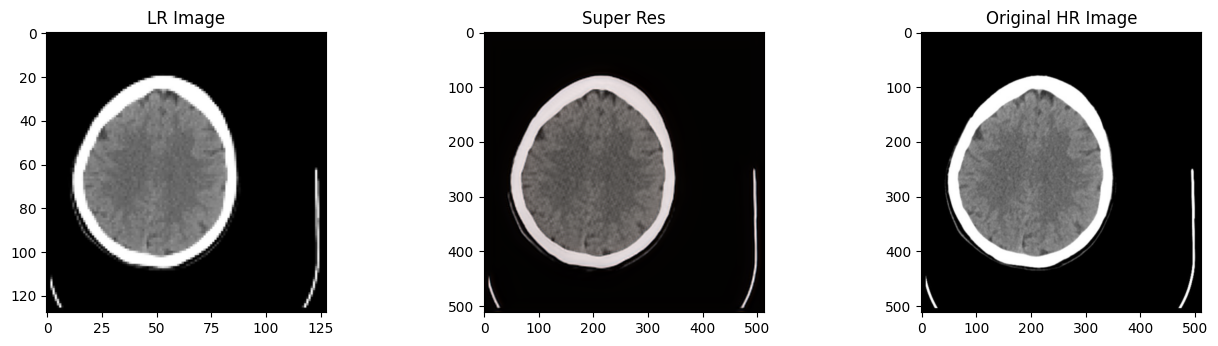

In [25]:
generator = load_model('gen_e_8.h5', compile = False)
[X1, X2] = [lr_test, hr_test]
#Selecting Random Test Sample
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

#Generating Image From Soruce
gen_image = generator.predict(src_image)

#Plotting All Three Images
plt.figure(figsize = (16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Super Res')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Original HR Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

LPIPS METRICS